# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Задача - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Imports

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image
import seaborn as sns
import numpy as np

img_path = 'img_path'

## EDA

In [2]:
labels = pd.read_csv(img_path)
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
print("\nСемпл:")
print(labels.sample(5))


Семпл:
       file_name  real_age
6734  006741.jpg        30
3202  003202.jpg        32
2243  002243.jpg        39
2886  002886.jpg         2
610   000610.jpg        14


In [4]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [5]:
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


В датасете нет пропусков и пропусков.

In [6]:
print('Пропусков:\n', labels.isnull().sum())
print('Дубликатов:' ,labels.duplicated().sum())

Пропусков:
 file_name    0
real_age     0
dtype: int64
Дубликатов: 0


Распределение:

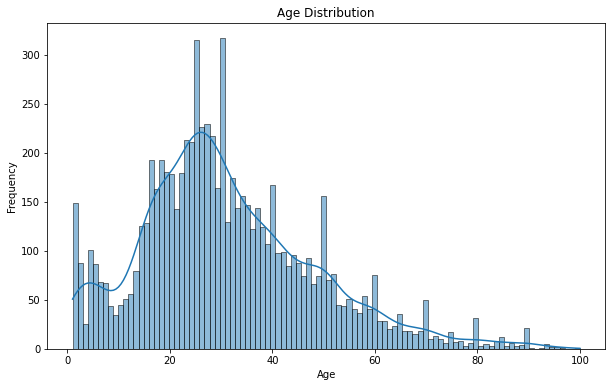

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Как видим, распределение данных похоже на нормальное, со смещением влево. Видны пики у значений 0 и 25, так же выбиваются все значения возрастов, кратные 10 - полагаю, это связано с особенностями составления датасета. Меньше всего данных по детям в возрасте ~10 лет. Можно посмотреть на боксплот:

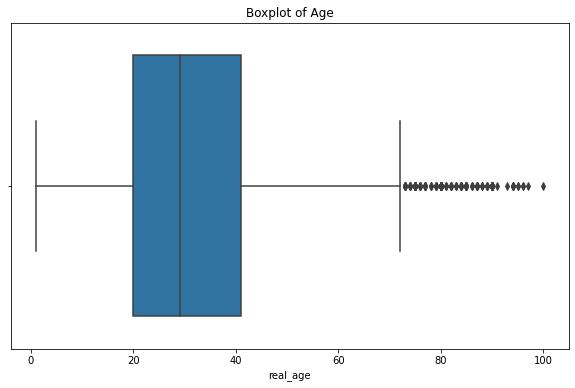

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=labels['real_age'])
plt.title('Boxplot of Age')
plt.show()




























































































 































Изобразим 15 изображений чтобы понять, как устроен датасет.

In [9]:
def plot_images(generator, num_images):
    images, ages = next(generator)

    indices = np.random.choice(range(len(images)), size=num_images, replace=False)

    plt.figure(figsize=(20, 20))
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Age: {int(ages[idx])}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

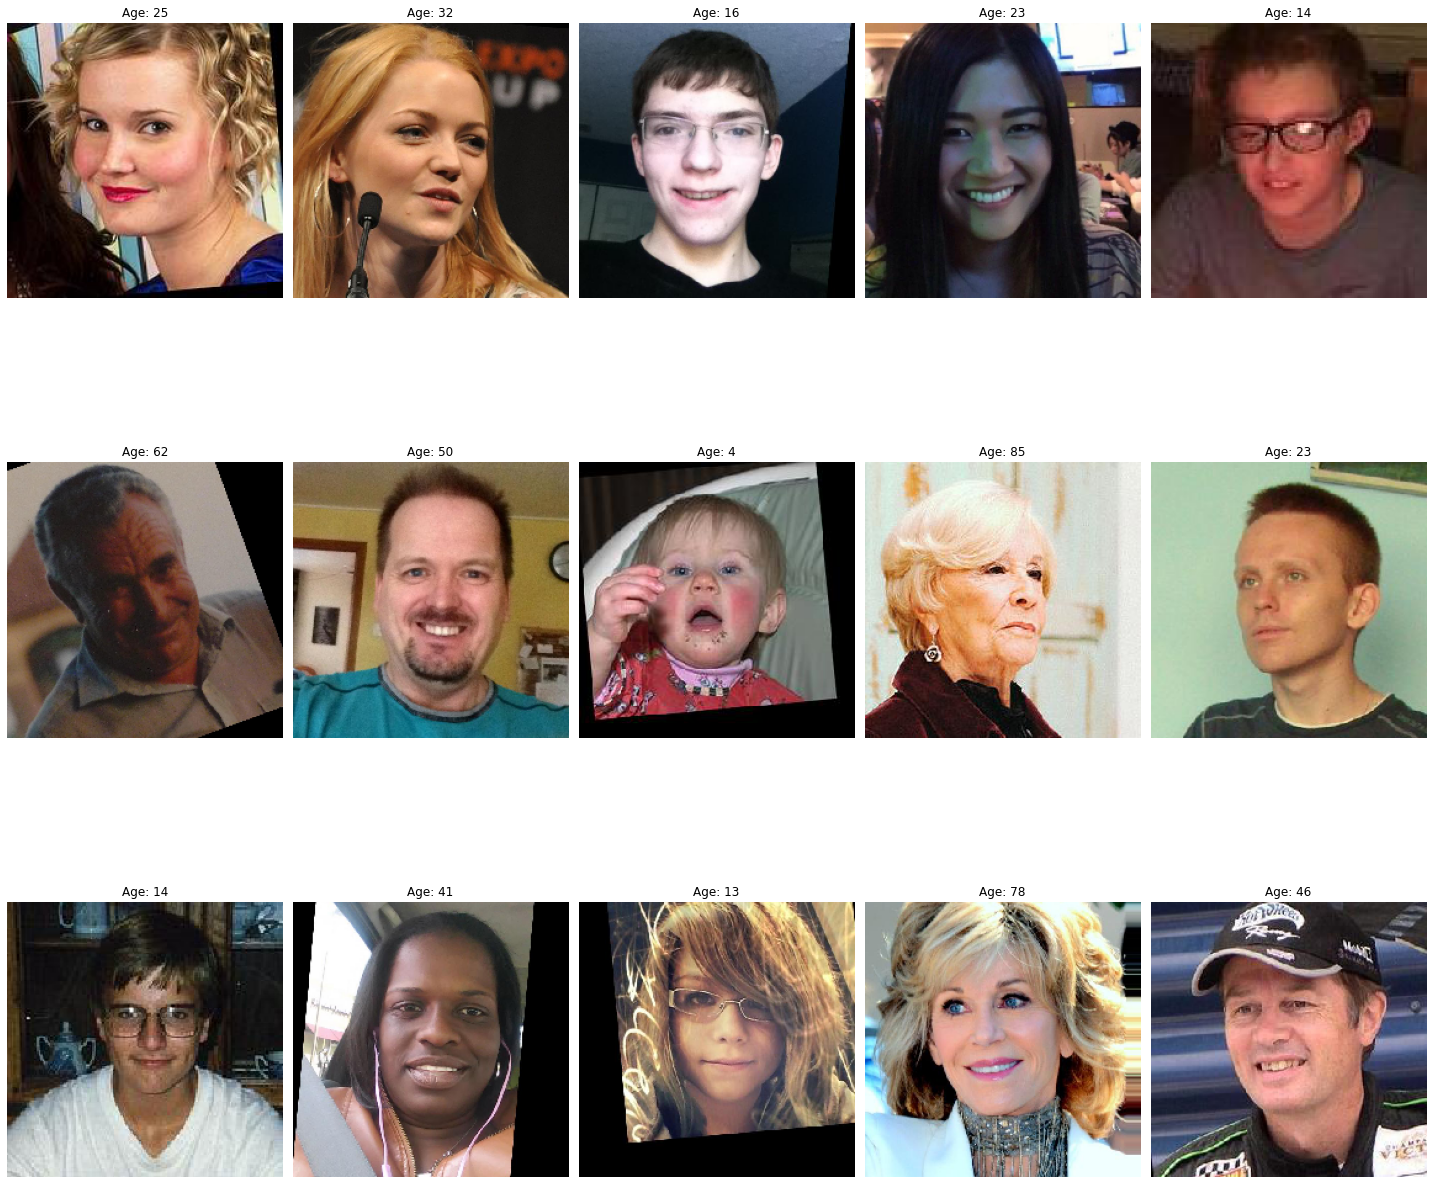

In [10]:
plot_images(train_gen_flow, 15)

 Изображения квадратные, лица в центре. Посмотрим на разрешение 10 случайных портретов:

In [11]:
random_indices = np.random.choice(labels.index, size=10, replace=False)
random_files = labels.loc[random_indices, 'file_name']

image_sizes = [(fname, Image.open(img_path + fname).size) for fname in random_files]

for fname, (width, height) in image_sizes:
    print(f"File: {fname}, Width: {width}, Height: {height}")

File: 000338.jpg, Width: 390, Height: 390
File: 000207.jpg, Width: 397, Height: 397
File: 006970.jpg, Width: 426, Height: 640
File: 002667.jpg, Width: 111, Height: 111
File: 004868.jpg, Width: 978, Height: 978
File: 006321.jpg, Width: 180, Height: 180
File: 005111.jpg, Width: 308, Height: 307
File: 000018.jpg, Width: 212, Height: 212
File: 002748.jpg, Width: 362, Height: 362
File: 004617.jpg, Width: 632, Height: 562


Как видим, разрешение разное, но это не проблема, ImageDataGenerator зарескейлит их в изображения (224,224). 

Также во время исследования датасета я обнаружил несколько проблемных фотографий. Они были либо не портретные, либо содержали несколько людей, либо не содержали людей вообще. Особенно меня очаровал этот пример:

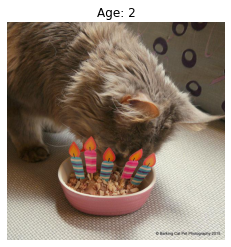

In [12]:
filename_cat = "002460.jpg"
image_row = labels[labels['file_name'] == filename_cat]

age = image_row['real_age'].values[0]

image_path = f"/datasets/faces/final_files/{filename_cat}"
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Age: {age}")
plt.axis('off')
plt.show()

Такие ошибки в составлении датасета могут повлиять на качество обучения модели, но их, наверное, немного.

### Выводы по EDA

Был проведен простой EDA. Подробно посмотрели на распределение возрастов в датафрейме, визуально оценили изображения, с которыми предстоит работать модели, убедились что в разметках нет дубликатов и пропусков. 
Нашли некоторые проблемы с датафреймом, не на всех изображениях находятся портретные изображения, некоторые изображения не содержат людей вообще, остается надеяться что таких изображений немного.

## Обучение модели

Обучать модели будем на предоставленом сервере Yandex Compute Cloud. Выполняются следующие функции:
* `load_train()` - загрузка тренировочного датасета
* `load_test()` - загрузка тестового датасета
* `create_model()` - создание архитектуры сети 
* `train_model()` - обучение модели

Описание архитектуры сети:
* Выбранная архитектура - `ResNet50` с добавленным полносвязным слоем с функцией активации ReLU для выполнения задачи регрессии
* Алгоритм оптимизации - `Adam` с `lr = 0.0005` с вызовом `ReduceLROnPlateau`, уменьшающем `lr` в случае выхода `val_loss` на плато, с параметрами `factor = 0.2`, `patience = 5`
* Вызов `EarlyStopping` с `patience = 10` при остановке улучшения `val_loss`
* Добавлен регулялизирующий слой `model.add(Dropout(0.5))` после пулинга для предотвращения оверфиттинга

### Код:

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42,
    )

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42,
    )

def create_model(input_shape):
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))  # Дропаут
    model.add(Dense(1, activation='relu')) # Полносвязный нейрон с ReLU
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)  # Early Stopping
    reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)   # ReduceLROnPlateau
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True,
        callbacks=[early_stopping, reduce_lr])
    return model
```

### Логи:

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 148s - loss: 206.2492 - mean_absolute_error: 10.8572 - val_loss: 431.9290 - val_mean_absolute_error: 15.6495
Epoch 2/20
178/178 - 92s - loss: 131.8275 - mean_absolute_error: 8.7384 - val_loss: 359.0117 - val_mean_absolute_error: 14.0519
Epoch 3/20
178/178 - 91s - loss: 113.0680 - mean_absolute_error: 8.0624 - val_loss: 293.7587 - val_mean_absolute_error: 12.8395
Epoch 4/20
178/178 - 91s - loss: 101.0810 - mean_absolute_error: 7.6180 - val_loss: 263.4191 - val_mean_absolute_error: 12.0951
Epoch 5/20
178/178 - 91s - loss: 95.5881 - mean_absolute_error: 7.3744 - val_loss: 151.4424 - val_mean_absolute_error: 9.8224
Epoch 6/20
178/178 - 91s - loss: 92.5947 - mean_absolute_error: 7.3441 - val_loss: 130.9813 - val_mean_absolute_error: 8.3791
Epoch 7/20
178/178 - 91s - loss: 85.9686 - mean_absolute_error: 7.0079 - val_loss: 120.3309 - val_mean_absolute_error: 8.0707
Epoch 8/20
178/178 - 91s - loss: 79.3561 - mean_absolute_error: 6.7871 - val_loss: 85.0185 - val_mean_absolute_error: 7.1200
Epoch 9/20
178/178 - 91s - loss: 72.8987 - mean_absolute_error: 6.4950 - val_loss: 77.0471 - val_mean_absolute_error: 6.5213
Epoch 10/20
178/178 - 91s - loss: 67.1611 - mean_absolute_error: 6.2391 - val_loss: 258.0890 - val_mean_absolute_error: 12.8528
poch 11/20
178/178 - 91s - loss: 63.6109 - mean_absolute_error: 6.0377 - val_loss: 97.5971 - val_mean_absolute_error: 7.4462
Epoch 12/20
178/178 - 91s - loss: 70.1321 - mean_absolute_error: 6.3635 - val_loss: 164.5520 - val_mean_absolute_error: 9.3054
Epoch 13/20
178/178 - 91s - loss: 63.9259 - mean_absolute_error: 6.0565 - val_loss: 85.3801 - val_mean_absolute_error: 6.9149
Epoch 14/20
178/178 - 91s - loss: 56.5324 - mean_absolute_error: 5.7882 - val_loss: 91.6307 - val_mean_absolute_error: 7.0451
Epoch 15/20
178/178 - 91s - loss: 41.2933 - mean_absolute_error: 4.9617 - val_loss: 69.6548 - val_mean_absolute_error: 6.0837
Epoch 16/20
178/178 - 91s - loss: 34.6994 - mean_absolute_error: 4.5407 - val_loss: 64.1769 - val_mean_absolute_error: 5.8164
Epoch 17/20
178/178 - 91s - loss: 31.6691 - mean_absolute_error: 4.3459 - val_loss: 72.4300 - val_mean_absolute_error: 6.3683
Epoch 18/20
178/178 - 91s - loss: 29.1945 - mean_absolute_error: 4.1583 - val_loss: 64.5599 - val_mean_absolute_error: 5.8242
Epoch 19/20
178/178 - 91s - loss: 27.3357 - mean_absolute_error: 4.0363 - val_loss: 65.0026 - val_mean_absolute_error: 5.9522
Epoch 20/20
178/178 - 91s - loss: 26.1695 - mean_absolute_error: 3.9563 - val_loss: 64.7102 - val_mean_absolute_error: 5.9551
60/60 - 10s - loss: 64.7102 - mean_absolute_error: 5.9551
Test MAE: 5.9551
```

## Вывод, анализ обученной модели

### Архитектура

Модель была построена на архитектуре ResNet50 в качестве бэкбона. Предобученные веса были загружены из файла `resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5`. Голова модели состоит из следующих слоев:

* GlobalAveragePooling2D
* Dropout слой с вероятностью 0.5
* Полносвязный слой с одним нейроном и активацией ReLU

Модель была обучена с использованием следующих параметров:

* Размер батча: 32
* Оптимизатор: Adam с lr = 0.0005
* Заморозка весов не использовалась
* Количество эпох: 20

Для предотвращения переобучения были применены два колбэка:

* `EarlyStopping` с параметром patience=10 и восстановлением лучших весов
* `ReduceLROnPlateau` с фактором уменьшения 0.2, patience 5 

### Результаты

Логи показывают улучшение метрик на протяжении всех эпох, значительного переобучения не наблюдается.

MAE равное 5.9551 на тестовом наборе указывает на то, что в среднем прогнозы модели отклоняются от правды примерно на 6 лет. Я думаю это более чем приемлемо в контексте того, что в датасете присутствуют коты и того факта, что в статье об этом датасете значение MAE равно 5.4. Тем не менее модель, призванная на в том числе то, чтобы контролировать добросовестность кассиров при продаже алкоголя, вряд ли может позволить себе ошибку в 6 лет.

Мои предложения по улучшению модели были бы такими: 
* Попробовать более аггрессивные аугментации
* Добавление большего числа регуляризирующих Dropout или L2 слоев
* Эксперименты с другими ResNet архитектурами
* Сборка более качественного датасета (без котов)